In [1]:
import json
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
def generate_df(K, dataset_folder, dataset):
    models = ["baseline", "lam0", "lam1", "lam2", "lam3", "clear"]
    metrics = ["acc", "roc", "pr"]
    
    # Initialize dictionaries to store metrics
    metrics_data = {model: {metric: [] for metric in metrics} for model in models}

    # Iterate through relevant files
    base_path = f"../expr_output/{dataset_folder}/classification"
    for file_name in os.listdir(base_path):
        if file_name.startswith(f"{dataset}-k{K}") and file_name.endswith(".json"):
            with open(os.path.join(base_path, file_name), "r") as f:
                data = json.load(f)
                for model in models:
                    try:
                        for metric in metrics:
                            if metric == "roc" or metric == "pr":
                                metrics_data[model][metric].append(data[model][metric]["overall"])
                            else:
                                metrics_data[model][metric].append(data[model][metric])
                    except KeyError:
                        continue

    # Create the main DataFrame
    df = pd.DataFrame(
        {
            "acc": sum([metrics_data[model]["acc"] for model in models], []),
            "roc": sum([metrics_data[model]["roc"] for model in models], []),
            "pr": sum([metrics_data[model]["pr"] for model in models], []),
            "model": sum([[model] * len(metrics_data[model]["acc"]) for model in models], []),
        }
    )
    df["K"] = K

    # Calculate relative metrics and create the relative DataFrame

    rel_df = pd.DataFrame(
        {
            metric: sum(
                [
                    (np.array(metrics_data[model][metric]) / np.array(metrics_data["baseline"][metric])).tolist()
                    for model in models[1:]
                ],
                []
            )
            for metric in ["acc", "roc", "pr"]
        }
    )
    rel_df["model"] = [model for model in models[1:] for _ in range(len(metrics_data[model]["acc"]))]
    rel_df["K"] = K

    return rel_df

In [20]:
dfs = []
for i in range(1, 6):
    dfs.append(generate_df(i, "styled-mnist", "styledmnist"))
df = pd.concat(dfs)

ValueError: operands could not be broadcast together with shapes (4,) (5,) 

In [17]:
df["model"] = df["model"].replace(
    {
        "clear": "CLEAR-PS",
        "lam0": "LAM ($\lambda$=0.0001)",
        "lam1": "LAM ($\lambda$=0.001)",
        "lam2": "LAM ($\lambda$=0.01)",
        "lam3": "LAM ($\lambda$=0.1)",
        "lam4": "LAM ($\lambda$=1)",
    }
)
df.head()

,acc,roc,pr,model,K
0,0.756098,1.029038,1.008130,LAM ($\lambda$=0.001),1
1,0.798077,1.101667,1.263889,LAM ($\lambda$=0.001),1
2,1.250000,1.094643,1.184874,LAM ($\lambda$=0.001),1
3,1.041899,1.002743,0.990566,LAM ($\lambda$=0.001),1
4,0.414634,1.032668,0.967480,LAM ($\lambda$=0.01),1


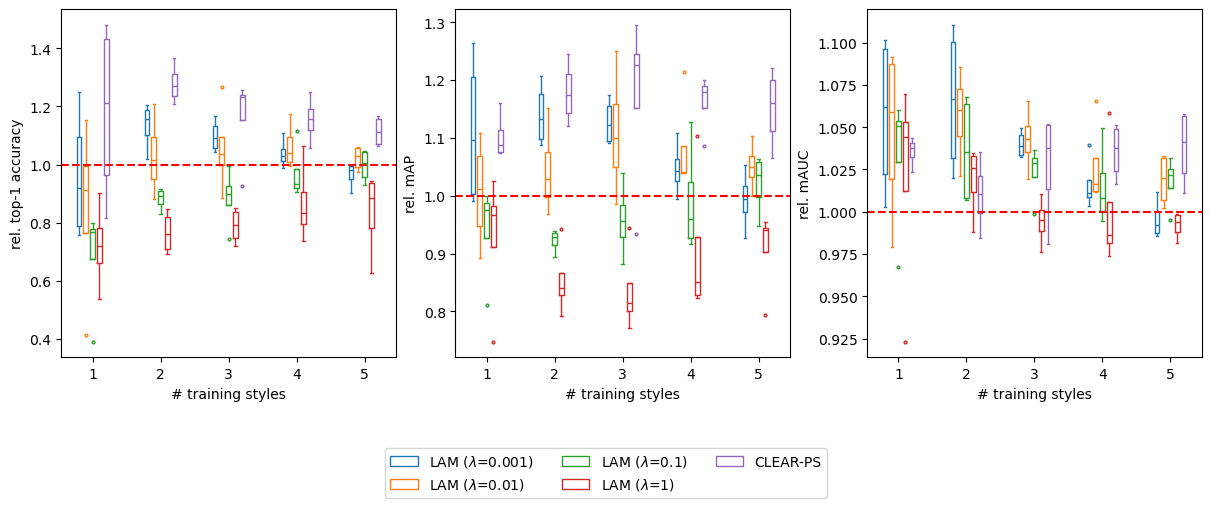

In [16]:
plot_config = {
    "hue": "model",
    "width": 0.5,
    "linewidth": 1,
    "fill": False,
    "gap": 0.3,
    "flierprops": {"marker": "o", "markersize": 2},
}


fig, axes = plt.subplots(1, 3, figsize=(12, 4), constrained_layout=True)

# Plot 1: Top-1 Accuracy
sns.boxplot(data=df, x="K", y="acc", **plot_config, ax=axes[0]).set(
    xlabel='# training styles',
    ylabel='rel. top-1 accuracy'
)
axes[0].axline(xy1=(0, 1), slope=0, color='r', linestyle='--')

# Plot 2: mAP
sns.boxplot(data=df, x="K", y="pr", **plot_config, ax=axes[1]).set(
    xlabel='# training styles',
    ylabel='rel. mAP'
)
axes[1].axline(xy1=(0, 1), slope=0, color='r', linestyle='--')

# Plot 3: mAUC
sns.boxplot(data=df, x="K", y="roc", **plot_config, ax=axes[2]).set(
    xlabel='# training styles',
    ylabel='rel. mAUC'
)
axes[2].axline(xy1=(0, 1), slope=0, color='r', linestyle='--')

# Remove individual legends
for ax in axes:
    ax.get_legend().remove()

# Create shared legend
handles, labels = axes[0].get_legend_handles_labels()
fig.legend(handles, labels, loc='lower center', ncol=3, fontsize=10, title='',
           bbox_to_anchor=(0.5, -0.25))

plt.show()

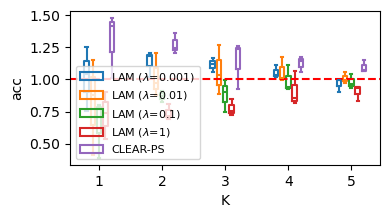

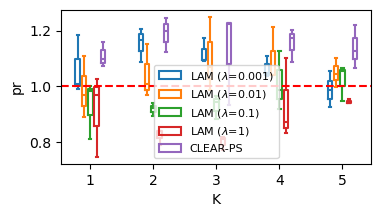

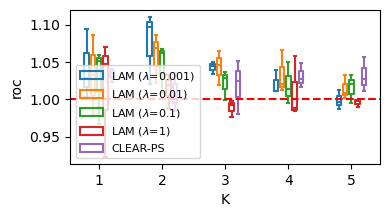

In [9]:
plt.subplots(figsize=(4, 2))
sns.boxplot(data=df, x="K", y="acc", hue="model", width=0.5, fill=False, gap=0.3,
            flierprops={'marker': 'o', 'markersize': 3})
plt.axline(xy1=(0, 1), slope=0, color='r', linestyle='--')
plt.legend(fontsize=8, title="")
plt.show()

plt.subplots(figsize=(4, 2))
sns.boxplot(data=df, x="K", y="pr", hue="model", width=0.5, fill=False, gap=0.3,
            flierprops={'marker': 'o', 'markersize': 3})
plt.axline(xy1=(0, 1), slope=0, color='r', linestyle='--')
plt.legend(fontsize=8, title="")
plt.show()

plt.subplots(figsize=(4, 2))
sns.boxplot(data=df, x="K", y="roc", hue="model", width=0.5, fill=False, gap=0.3,
            flierprops={'marker': 'o', 'markersize': 3})
plt.axline(xy1=(0, 1), slope=0, color='r', linestyle='--')
plt.legend(fontsize=8, title="")
plt.show()